# Model Evaluation

This script evaluates the performance of the air pollution prediction GAM.

As input are needed:
- the name of the chosen variable (i.e. air pollutant)
- a dataframe containing the observations of weather variables and air pollutants (as produced by the script "Generate Variables")
- a dataframe containing the selected explanatory variables for the models for each station (as produced by the script "Model Selection")

## Load Libraries & Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shapefile as shp
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from pygam import LinearGAM, LogisticGAM, s, f,l, GAM, te
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import math
import sklearn.mixture as mix
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import re
from scipy import stats
from functions import GAMf, time_plot_conf, curves, GAMf_train_test
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go
import plotly.express as px
from dictionaries import starts, ends, che_classes, beijing_classes, wuhan_classes, at_classes, loc_classes

In [2]:
loc = 'che'

In [3]:
# set matplotplit style
plt.style.use('seaborn')

In [4]:
# choose pollutant to examine
in_var = 'no2'
IN_VAR = in_var.upper()

In [5]:
# read in dataframe with chosen variables as produced by the variable selection algorithm
chosen_vars = pd.read_csv('./' + loc+  '/' +in_var+'_chosen_vars.csv', index_col =0)

In [6]:
# read in dataset of explanatory & independent variables observations as produced by the variable generation script
data_path =  './' + loc +'/' + 'df2.csv'
df = pd.read_csv(data_path, index_col = 0)

In [7]:
# convert index to datetime format
df.index = pd.to_datetime(df.index)

In [8]:
# as we are working with a log normal distribution, 0 values for the independent variable cannot be processed 
# they are replaced by a very low non zero number
df[in_var] = df[in_var].replace(0,0.0001)

In [9]:
# drop all columns with NaN values, infinite values or values negative values for the observed variable
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[in_var])
df = df.drop(df[df[in_var]<0].index)

In [10]:
# get vector with names of all cities
cities = np.unique(df['city'].values)

# Model Performance Evaluation

To evaluate the model performance we perform cross validation with the data for the year 2019. Taking into account the temporal dependencies in the air pollution data, the models for different stations are fitted on 3, 6, 9, 12, 18 and 24 months of train data prior to a chosen date and tested on the data from the subsequent month. The chosen cut-off date is the start of each month in the year 2019.

In [11]:
# load potential classes
classes = loc_classes[loc]

In [12]:
ex_vars_all = ['t', 'h', 'ws', 'dew',
 'pca', 'lagpca_year', 'lagpca_halfyear', 'lagpca_12weeks', 'lagpca_8weeks',
 'lagpca_4weeks', 'lagpca_2weeks', 'lagpca_1week', 'lagws_4weeks',
 'lagws_2weeks', 'lagws_1week', 'lagws_4weeks_max', 'lagws_2weeks_max',
 'lagws_1week_max', 'year', 'weekday', 'month', 'wx', 'wy', 'julian', 'h_lag1',
 't_lag1', 'wx_lag1', 'wy_lag1', 'ws_lag1', 'dew_lag1', 'h_lag2', 't_lag2',
 'wx_lag2', 'wy_lag2', 'ws_lag2', 'dew_lag2', 'h_lag3', 't_lag3', 'wx_lag3',
 'wy_lag3', 'ws_lag3', 'dew_lag3']

In [13]:
# generate column names for output dataframe
col_names = []
model_names = []
for i in range(1,13):
    col_names.append('RMSE_train_'+str(i))
    col_names.append('RMSE_test_'+str(i))
    col_names.append('R_squared_'+str(i))
    col_names.append('FAC2_'+str(i))
    col_names.append('testdays_'+str(i))
    col_names.append('traindays_'+str(i))
    col_names.append('ratio_'+str(i))
    col_names.append('avg_err_'+str(i))
    model_names.append('model_'+str(i))

In [14]:
# calculate gam models with the respectively chosen variables & predict the different months in 2019
# predictions are only made when training data contains at least one year of data!
out = pd.DataFrame(data = None, index = cities, columns = col_names)
out_gam = pd.DataFrame(data = None, index = cities, columns = model_names)
preds_all = pd.DataFrame(data = None, index = cities, columns = model_names)

whisker_data = pd.DataFrame(data = None)

crossV_train = pd.DataFrame(data =None, index = cities, columns = [3,6,9,12,18,24])
crossV_test = pd.DataFrame(data =None, index = cities, columns = [3,6,9,12,18,24])


for i in range(1,13):
    for j in [3,6,9,12,18,24]:
        for city in cities:
            ex_vars = chosen_vars.loc[city].dropna().values.tolist()
            # ex_vars.append('weekday')
            cut = str(i) + '/' + str(1)+ '/' + str(2019)
            
            #if 'weekday' not in chosen_vars:
            ex_vars.append('weekday')
        
            out_gam.loc[city, model_names[i-1]], out.loc[city, col_names[8*i-8]:col_names[8*i-1]], preds_all.at[city, model_names[i-1]] =  GAMf_train_test(df, in_var, ex_vars, city, cut,pred_end = 'one_month', train_duration = j)
            
            
            whisker_list = [city, j, out.loc[city, col_names[8*(i-1)]], out.loc[city, col_names[8*(i-1)+1]], classes[city]]
            whisker_data = whisker_data.append([whisker_list])
            
            
        crossV_train[j] = out.loc[:, out.columns.str.startswith('RMSE_train')].mean(axis=1)
        crossV_test[j] = out.loc[:, out.columns.str.startswith('RMSE_test')].mean(axis=1)

In [15]:
# rename columns
whisker_data = whisker_data.rename(columns={0:'city', 1: 'train_len', 2:'train_RMSE', 3:'test_RMSE', 4: 'class'})
whisker_data['train_len'] = whisker_data['train_len'].astype('float64')

In [16]:
# calculate mean, maximum value and minimum value for each station
city_mean = pd.Series(data= None, index = cities)
city_max = pd.Series(data= None, index = cities)
city_min = pd.Series(data= None, index = cities)

# add columns with the mean, max and min values
for city in cities:
    df_city = df[df['city']==city]
    df_city =df_city[df_city.index.year >= 2017]
    
    city_mean.loc[city] = df_city[df_city.index.year < 2020][in_var].mean()
    city_max.loc[city] = df_city[df_city.index.year <2020][in_var].max()
    city_min.loc[city] = df_city[df_city.index.year <2020][in_var].min()

out['mean'] = city_mean
out['max'] = city_max
out['min'] = city_min
out['diff'] = out['max'] - out['min']

/Users/abhiram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/abhiram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/abhiram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [17]:
# plot table with summary data
pd.set_option('precision', 2)

out_summary = pd.DataFrame(data = None, index = cities, columns = ['RMSE', 'Relative RMSE', 'R_Squared', 'FAC2', '# of Days predicted', '# of Days used for training'])

out_summary['RMSE'] = out.loc[:, out.columns.str.startswith('RMSE_test')].mean(axis=1)
out_summary['Relative RMSE'] = out.loc[:, out.columns.str.startswith('RMSE_test')].mean(axis=1)/out['diff']
out_summary['R_Squared'] = out.loc[:, out.columns.str.startswith('R_squared')].mean(axis=1)
out_summary['FAC2'] = out.loc[:, out.columns.str.startswith('FAC2')].mean(axis=1)
out_summary['# of Days predicted'] = out.loc[:, out.columns.str.startswith('testdays')].mean(axis=1)
out_summary['# of Days used for training'] = out.loc[:, out.columns.str.startswith('traindays')].mean(axis=1)
out_summary.loc['Mean',:]= out_summary.mean(axis=0)


out_summary

,RMSE,Relative RMSE,R_Squared,FAC2,# of Days predicted,# of Days used for training
Opfikon_Balsberg,7.97,0.10,0.68,1.00,29.25,726.58
StGallen_Blumenbergplatz,9.58,0.11,0.65,1.00,28.92,723.92
StGallen_Stuelegg,3.10,0.07,0.62,0.97,29.25,726.58
Zuerich_Schimmelstrasse,8.57,0.10,0.71,1.00,29.25,724.58
Zuerich_Stampfenbachstrasse,7.57,0.10,0.74,1.00,29.25,726.58
Mean,7.36,0.09,0.68,0.99,29.18,725.65


In [18]:
# calculate average statistics over all models

rmse_cols = [col for col in out.columns if 'RMSE' in col]
r_squared_cols = [col for col in out.columns if 'R_squared' in col]
avg_err_cols = [col for col in out.columns if 'avg_err' in col]
fac2_cols = [col for col in out.columns if 'FAC2' in col]


#avg_rmse = out[rmse_cols].mean().mean()
avg_r_squared = out[r_squared_cols].mean().mean()
avg_err = out[avg_err_cols].mean().mean()
avg_fac2 = out[fac2_cols].mean().mean()
mean_in_var = df[df.index < datetime.strptime('03/16/2020', '%m/%d/%Y')][in_var].mean()


print('The average root mean squared error over all stations & months is:', out[rmse_cols].mean(axis=1).mean())
print('The average pseudo R-squared over all stations & months is:', avg_r_squared)
print('The average difference between prediction & true value over all stations & months is:', avg_err)
print('The average FAC2 score over all stations & months is:', avg_fac2)
print('The average value of', in_var,' over all stations & months is: ', mean_in_var)

The average root mean squared error over all stations & months is: 6.82093682297882
The average pseudo R-squared over all stations & months is: 0.6779680044859799
The average difference between prediction & true value over all stations & months is: -1.610389486185608
The average FAC2 score over all stations & months is: 0.9948424861643254
The average value of no2  over all stations & months is:  29.015731440755918


## Smooth Graph Plot

Plots the partial dependencies of the independet variable with the explanatory variables.

<Figure size 576x396 with 0 Axes>

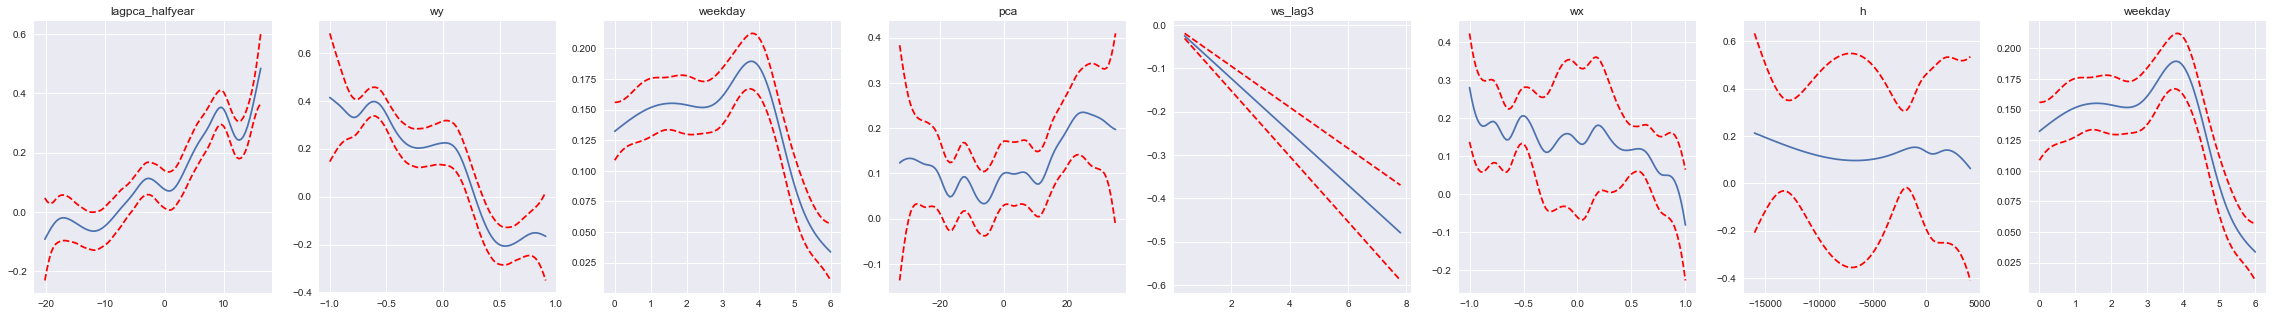

In [19]:
# plot smooth graph

@interact
def curve_plots(city = cities):
    gam_model = out_gam.loc[city,'model_12']
    ex_vars = chosen_vars.loc[city].dropna().values.tolist()
    ex_vars.append('weekday')
    curves(gam_model, ex_vars)

In [20]:
whisker_data.to_csv('./'+loc+'/'+in_var+'_whisker.csv')
out.to_csv('./'+loc+'/'+in_var+'_out.csv')